In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_error, make_scorer
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

/System/Library/anaconda/envs/python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#loading sample data
data = pd.read_csv('sample.csv')

In [3]:
# check dimensions and peak at first rows 
print(data.shape)
data.head(10)

(10000, 8)


,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50
5,0,03,1,Tue,483,1899.0,13.6,550.00
6,0,09,1,Mon,214,1000.0,3.0,210.00
7,7,74,1,Wed,452,330.0,3.0,366.67
8,8,89,1,Tue,130,8000.0,4.5,193.33
9,1,17,4,Fri,1004,3135.0,13.2,1400.00


Are there any nan values in the data?

In [4]:
data.isnull().any()

loc1     False
loc2     False
para1    False
dow      False
para2    False
para3    False
para4    False
price    False
dtype: bool

No missing values present, which would have to been addressed.

In [5]:
#take a look at the elementary statistics of the samples
data.describe()

,para1,para2,para3,para4,price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.380800,447.384000,9547.989920,8.459522,433.733056
std,3.500831,221.005861,8022.814037,4.613526,277.435947
min,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,301.000000,2898.000000,4.000000,250.000000
50%,1.000000,434.000000,6447.000000,7.200000,370.000000
75%,1.000000,582.000000,15000.000000,13.600000,550.000000
max,337.000000,2554.000000,34782.000000,27.200000,5700.000000


In [6]:
# check the correlation between numeric variables
print(data.corr())

          para1     para2     para3     para4     price
para1  1.000000  0.072025  0.010420  0.001663  0.074754
para2  0.072025  1.000000  0.006978  0.020806  0.552681
para3  0.010420  0.006978  1.000000  0.691237  0.355088
para4  0.001663  0.020806  0.691237  1.000000  0.514990
price  0.074754  0.552681  0.355088  0.514990  1.000000


The correlation is strongest between the target variable price und the parameters para2 and para4. The correlation is only weak between para 1 and the price. Therefore this variable is probably less important for the prediction than para2 and para4.

Plot the numeric variables against the target and try to fit a linear relationship:

<IPython.core.display.Javascript object>


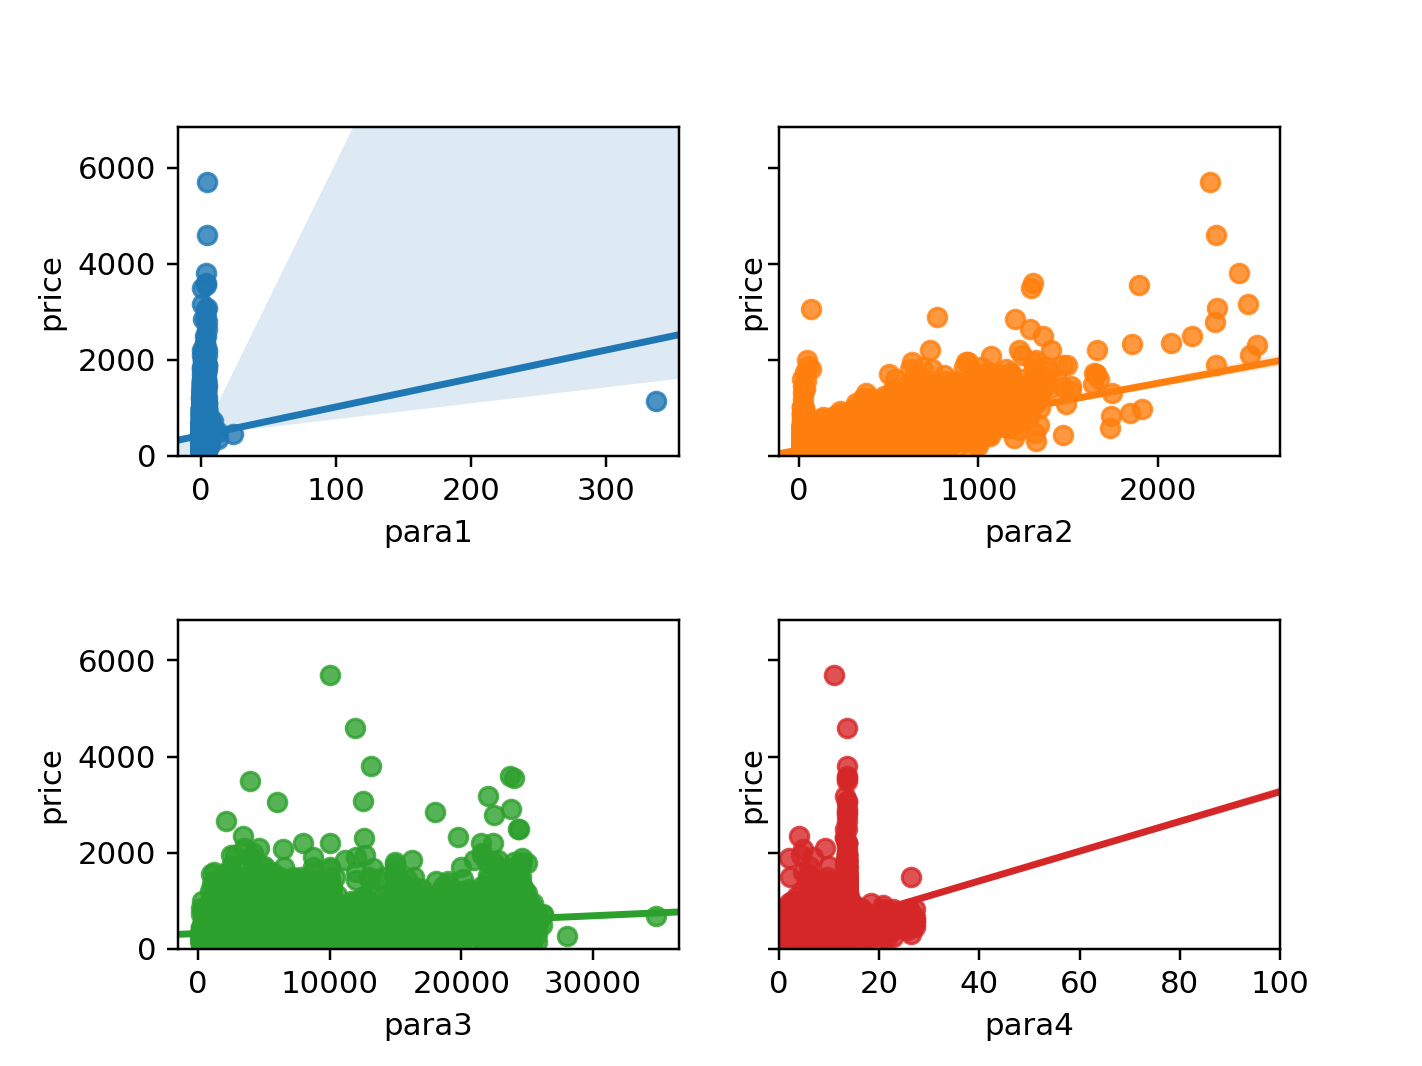

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row')
sns.regplot(x='para1', y='price', ax=axes[0, 0], data=data)
sns.regplot(x='para2', y='price', ax=axes[0, 1], data=data)
sns.regplot(x='para3', y='price', ax=axes[1, 0], data=data)
sns.regplot(x='para4', y='price', ax=axes[1, 1], data=data)
axes[0,0].set_ylim(0,1.2*data['price'].max())
axes[1,0].set_ylim(0,1.2*data['price'].max())
axes[1,1].set_xlim(0,100)
fig.subplots_adjust(hspace=.5)

One outlier can be identified for `para1`:

In [8]:
data[data['para1']>300]    

,loc1,loc2,para1,dow,para2,para3,para4,price
7196,6,63,337,Mon,442,25000.0,13.6,1150.0


In case of using a linear model we would erase the entry from the data because it can lead to fitting the line to the outlier(as can be seen in the plot).
When training a model based on decision trees
this is not necessary because the splits are based on thesholds.

Inspect the categorical data and the number of unique values for each category:


In [9]:
print('Number of unique categories for loc1: {}, loc2: {} and dow: {}'.format(data['loc1'].nunique(), data['loc2'].nunique(), data['dow'].nunique()))

Number of unique categories for loc1: 12, loc2: 107 and dow: 7


<IPython.core.display.Javascript object>


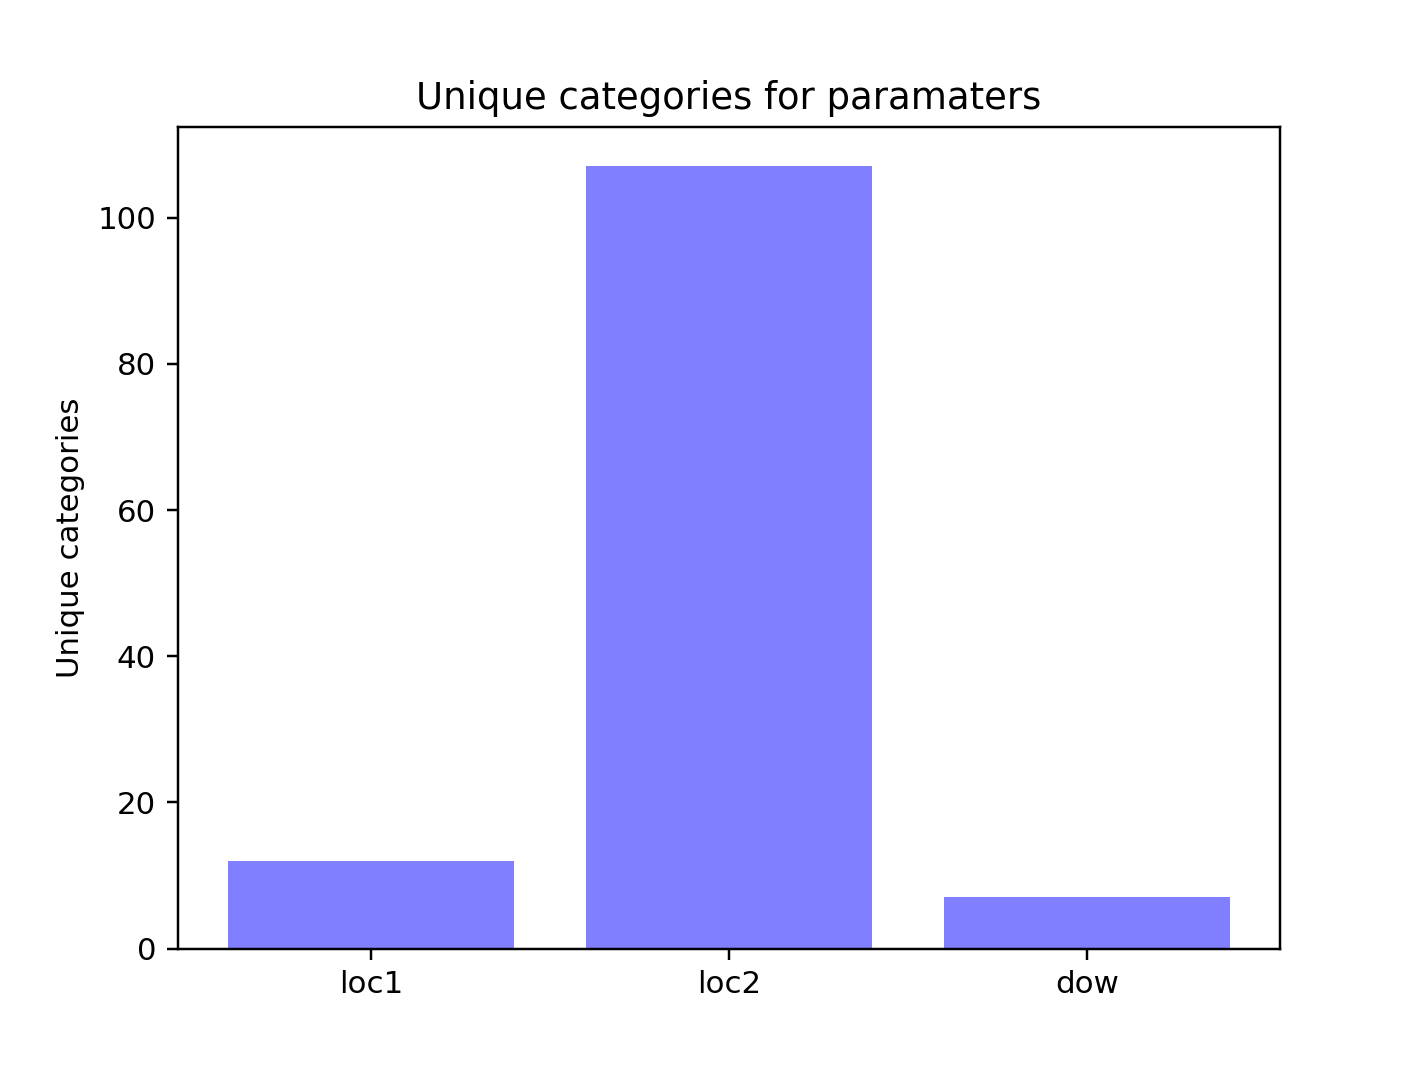

In [10]:
# Visualize number of unique categories
plt.figure()
nr_unique_cats = [data['loc1'].nunique(), data['loc2'].nunique(), data['dow'].nunique()]
x_labels=['loc1', 'loc2', 'dow']
x_pos = list(range(len(nr_unique_cats)))
plt.bar(x_pos, nr_unique_cats,  align='center', color='blue',alpha=0.5)
# set axes labels and title
plt.ylabel('Unique categories')
plt.xticks(x_pos, x_labels)
plt.title('Unique categories for paramaters')
plt.show()

List values for all categories:

In [11]:
print('Unique values loc1: {}'.format(data['loc1'].unique()))

Unique values loc1: ['0' '9' '4' '5' '7' '8' '1' '3' '2' '6' 'S' 'T']


In [12]:
print('Unique values loc2: {}'.format(data['loc2'].unique()))

Unique values loc2: ['01' '99' '04' '40' '50' '03' '09' '74' '89' '17' '34' '30' '21' '59' '28'
 '64' '14' '46' '19' '15' '90' '67' '85' '24' '12' '20' '23' '08' '06' '95'
 '37' '77' '73' '88' '66' '39' '41' '68' '47' '33' '35' '78' '54' '76' '51'
 '79' '16' '02' '29' '57' '45' '80' '31' '70' '22' '27' '87' '53' '75' '38'
 '26' '25' '63' '86' '97' '81' '13' '49' '32' '72' '71' '10' '94' '96' '93'
 '42' '48' '55' '91' '58' '60' '44' '52' '05' '36' '82' '56' '84' '65' '07'
 '92' '83' '18' '69' '98' '62' '00' '61' '0B' 'S6' '43' '0T' 'TS' '0L' '11'
 '0C' '0N']


In [13]:
print(Counter(data['loc2']))

Counter({'21': 499, '06': 454, '74': 329, '12': 273, '14': 246, '01': 241, '22': 226, '50': 217, '23': 215, '89': 194, '09': 192, '04': 180, '15': 168, '20': 168, '67': 167, '16': 166, '31': 160, '19': 149, '28': 149, '39': 146, '59': 142, '47': 139, '08': 137, '99': 133, '85': 130, '13': 128, '90': 127, '49': 127, '76': 123, '63': 119, '30': 118, '35': 118, '73': 113, '68': 112, '41': 111, '78': 109, '51': 108, '95': 107, '86': 104, '40': 101, '79': 101, '03': 100, '27': 95, '42': 91, '71': 88, '97': 88, '88': 87, '32': 87, '33': 82, '77': 81, '24': 79, '87': 78, '37': 76, '07': 75, '57': 75, '25': 74, '48': 70, '66': 68, '02': 63, '38': 62, '55': 61, '64': 59, '29': 59, '91': 58, '58': 57, '34': 53, '83': 50, '54': 50, '52': 49, '45': 48, '75': 46, '72': 46, '93': 45, '70': 45, '56': 44, '36': 43, '53': 43, '26': 43, '44': 43, '46': 42, '81': 40, '10': 39, '05': 38, '92': 37, '94': 35, '96': 35, '65': 34, '60': 31, '17': 28, '98': 25, '18': 24, '84': 24, '69': 15, '80': 11, '61': 10,

Values for `loc2` are mostly numeric. An additional feature is created that will be used for training the model.
Since the mean of the price for numeric and non-numeric `loc2` values differ, this could be valuable information for the price prediction. But since there are only six non-numeric `loc2` values the gain should be limited.

In [14]:
data['loc2_numeric'] = data['loc2'].map(lambda x: x.isdigit())
print('loc2 not numeric, price mean: {}'.format(data.loc[data['loc2_numeric']==False, 'price'].mean()))
print('loc2 numeric, price mean: {}'.format(data.loc[data['loc2_numeric']==True, 'price'].mean()))
print('loc2 non numeric values with prices:\n {}'.format(data.loc[data['loc2_numeric']==False, 'price']))

loc2 not numeric, price mean: 1025.7142857142858
loc2 numeric, price mean: 433.3183788652056
loc2 non numeric values with prices:
 2887    1350.0
3026     850.0
4850    1890.0
5510     440.0
5647     750.0
7751     400.0
8466    1500.0
Name: price, dtype: float64


In [15]:
data.head(10)

,loc1,loc2,para1,dow,para2,para3,para4,price,loc2_numeric
0,0,01,1,Mon,662,3000.0,3.8,73.49,True
1,9,99,1,Thu,340,2760.0,9.2,300.00,True
2,0,04,0,Mon,16,2700.0,3.0,130.00,True
3,4,40,1,Mon,17,12320.0,6.4,365.00,True
4,5,50,1,Thu,610,2117.0,10.8,357.50,True
5,0,03,1,Tue,483,1899.0,13.6,550.00,True
6,0,09,1,Mon,214,1000.0,3.0,210.00,True
7,7,74,1,Wed,452,330.0,3.0,366.67,True
8,8,89,1,Tue,130,8000.0,4.5,193.33,True
9,1,17,4,Fri,1004,3135.0,13.2,1400.00,True


The first character of `loc2` seems to be the same as `loc1`:

In [16]:
all(data['loc1']==data['loc2'].str[0])

True

Therefore we create an additional feature for the second character of `loc2`. 

In [17]:
data['loc2_2'] = data['loc2'].str[1]

Taking a look at the weekdays:

print('Unique values dow : {}'.format(data['dow'].unique()))

Counting the different values of `param1`, reveals that there not many different values and all except three are smaller than 10.
Judging from the distribution it could be tested if it is better to treat  `param1` as categorical variable.

In [18]:
print(Counter(data['para1']))

Counter({1: 7052, 3: 1613, 0: 836, 2: 268, 4: 164, 5: 51, 6: 6, 7: 3, 9: 2, 13: 2, 8: 1, 337: 1, 24: 1})


Counting the different values of `param1`, reveals that there not many different values and all except three are smaller than 10.
Judging from the distribution `param1` could be also treated as a categorical variable.

Plotting the price together with `para1` and the categorical variables.

<IPython.core.display.Javascript object>


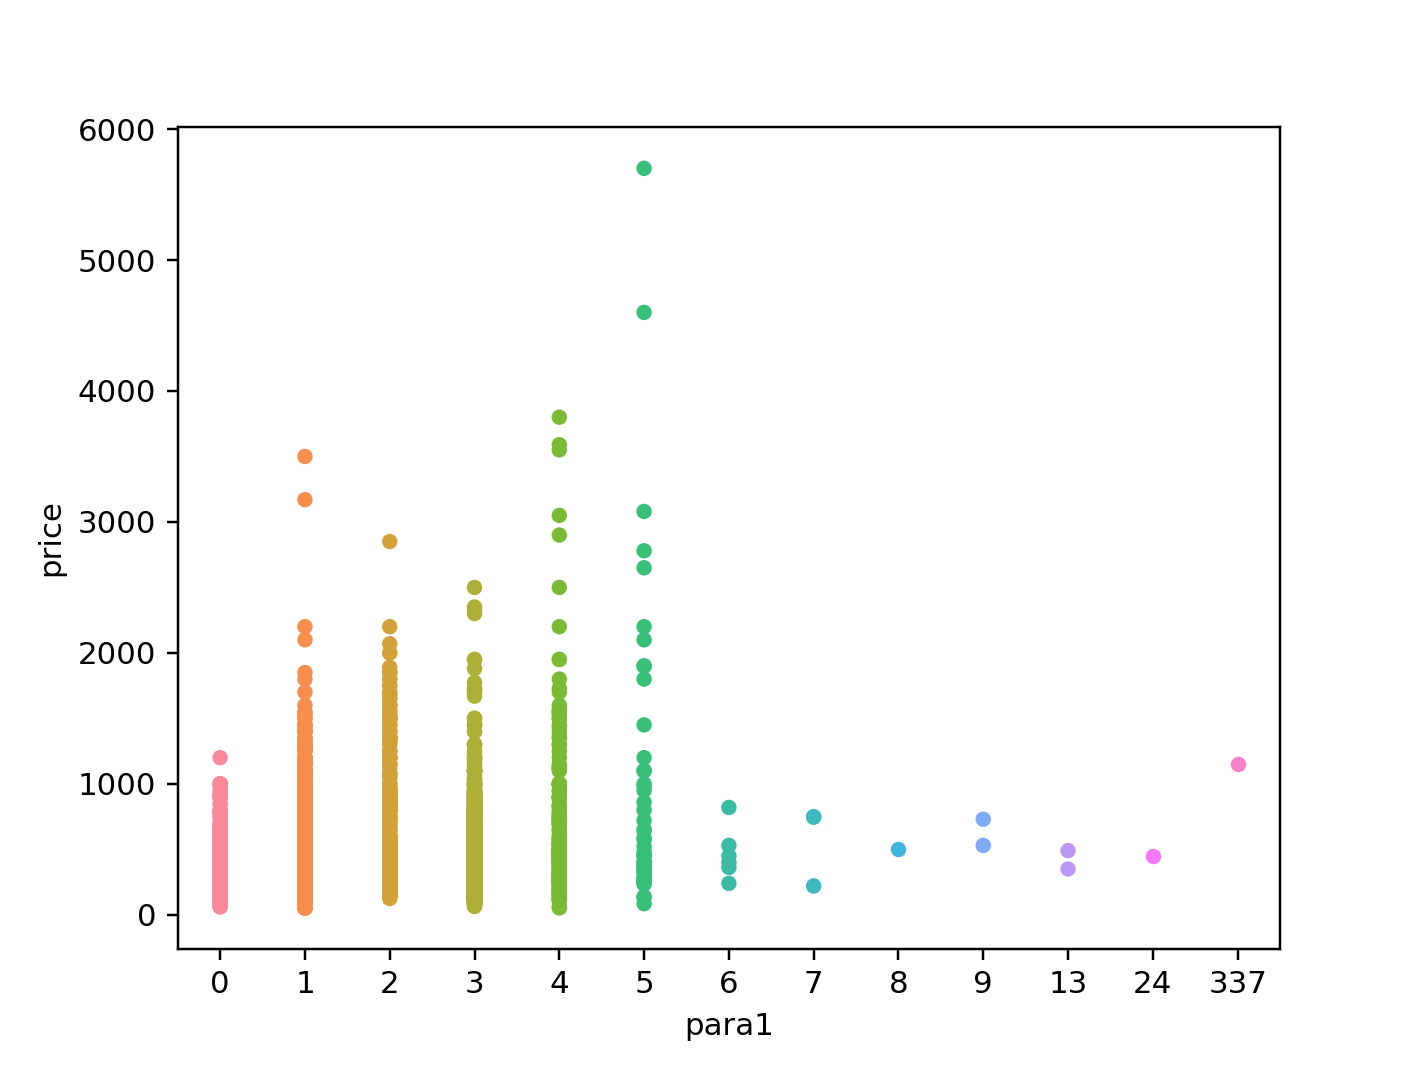

In [19]:
plt.figure()
sns.stripplot(x='para1', y='price', data=data)

<IPython.core.display.Javascript object>


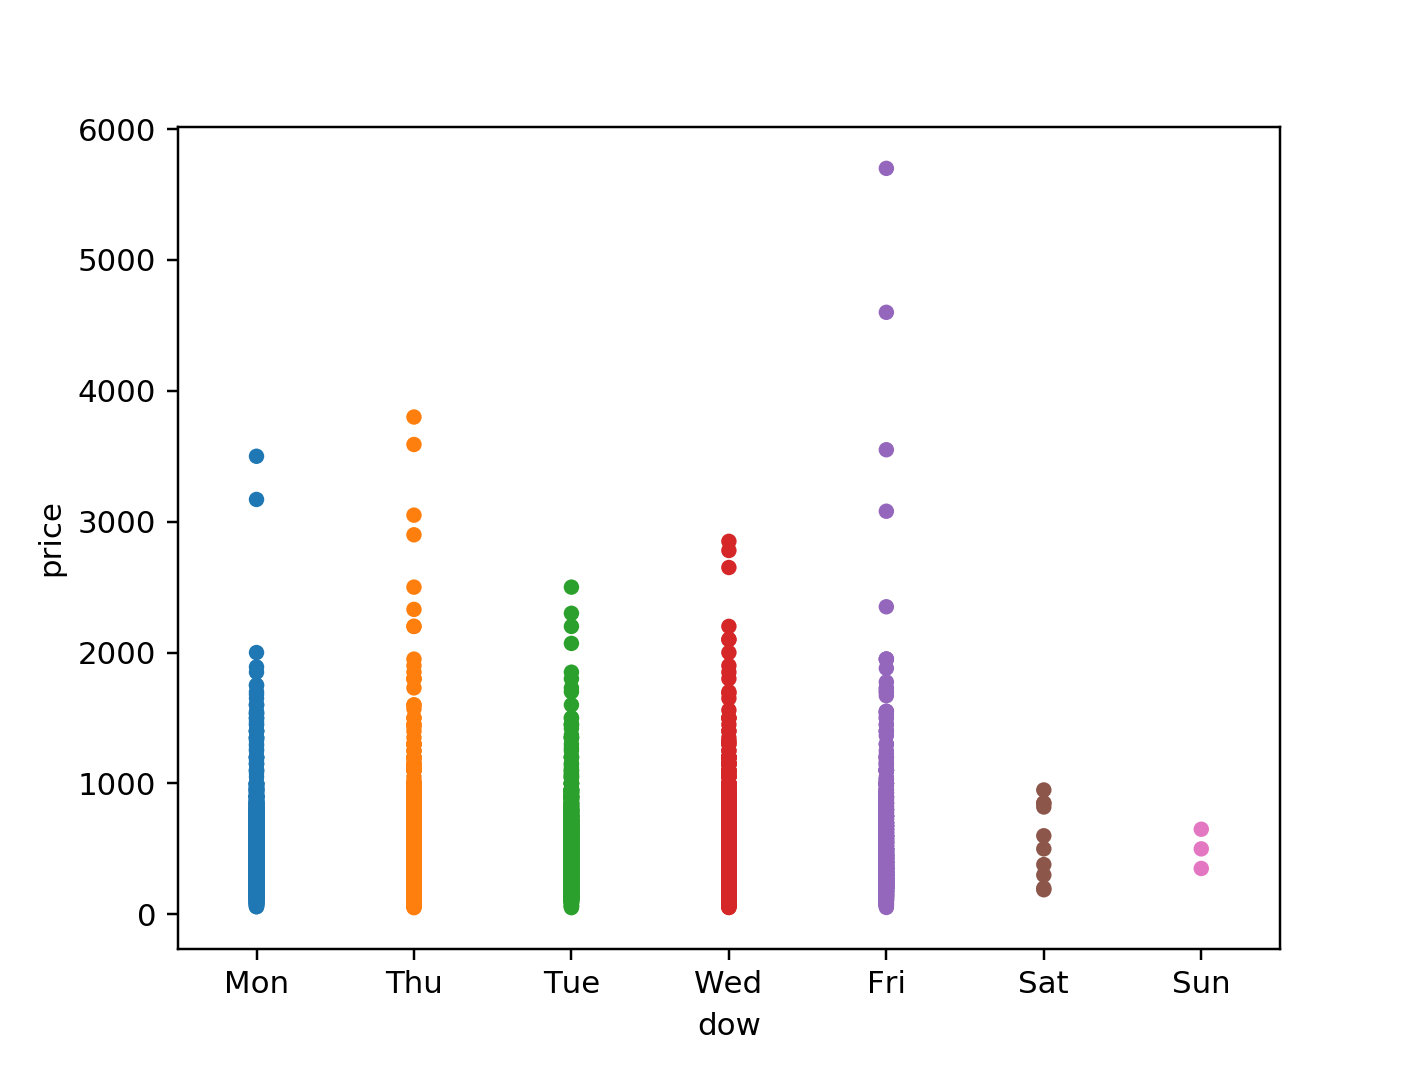

In [20]:
plt.figure()
sns.stripplot(x='dow', y='price', data=data)

We can see less activity on Saturday and Sunday. Higher prices are not reached on these days but the reason for this could be the smaller sample size. 

<IPython.core.display.Javascript object>


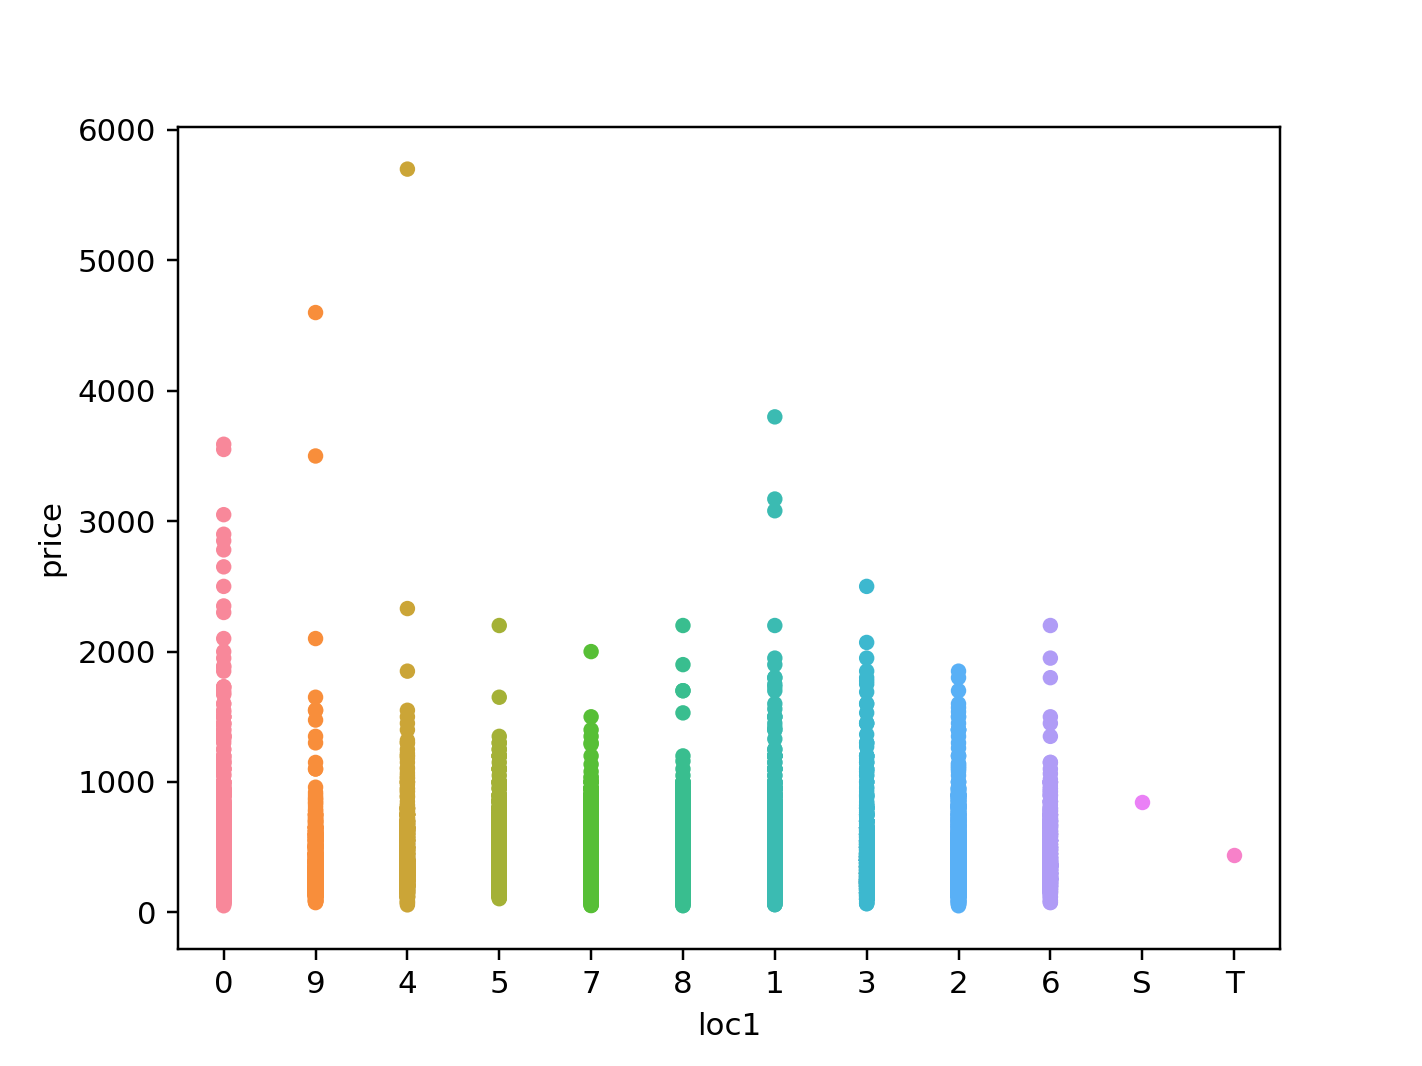

In [21]:
plt.figure()
sns.stripplot(x='loc1', y='price', data=data)

The only letters in the categories 'S' and 'T' appear only once. Because there can't be learned anything for this entries
we could remove them from the data.

Listing the datatypes in the data frame:

In [22]:
data.dtypes

loc1             object
loc2             object
para1             int64
dow              object
para2             int64
para3           float64
para4           float64
price           float64
loc2_numeric       bool
loc2_2           object
dtype: object

Transform the data to categorical data in the dataframe and create new columns with the codes for each category example:

In [23]:
for col, typ in zip(data.columns,data.dtypes):
    if typ == 'object':
        data[col] = data[col].astype('category')
        data[col+'_cat'] = data[col].cat.codes

Show mapping from codes to `dow` and from codes to `loc1`:


In [24]:
nr_day_map = {idx:day for idx, day in enumerate(data['dow'].cat.categories)}
print(nr_day_map)
nr_loc1_map = {idx:loc1 for idx, loc1 in enumerate(data['loc1'].cat.categories)}
print(nr_loc1_map)

{0: 'Fri', 1: 'Mon', 2: 'Sat', 3: 'Sun', 4: 'Thu', 5: 'Tue', 6: 'Wed'}
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'S', 11: 'T'}


Create a new column weekend, where less activity is  observed:

In [25]:
data['weekend'] = data['dow_cat'].map(lambda x: nr_day_map[x] in ['Sat', 'Sun'])

Remove obsolete columns from data:

In [26]:
data.drop(['loc1', 'loc2', 'dow', 'loc2_2'], axis=1, inplace=True)

Take a look at the changed dataframe:

In [27]:
data.head()

,para1,para2,para3,para4,price,loc2_numeric,loc1_cat,loc2_cat,dow_cat,loc2_2_cat,weekend
0,1,662,3000.0,3.8,73.49,True,0,1,1,1,False
1,1,340,2760.0,9.2,300.00,True,9,104,4,9,False
2,0,16,2700.0,3.0,130.00,True,0,4,1,4,False
3,1,17,12320.0,6.4,365.00,True,4,45,1,0,False
4,1,610,2117.0,10.8,357.50,True,5,55,4,0,False


We split the data in training and test set. The test set is hold back for evaluation purposes of our model.
To evaluate its ability for generalization it is important that the model is not trained with data in the test set.

In [28]:
y = data['price']
data.drop(['price'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=666)

In [29]:
# Set up folds for cross validation
K = 5
kf = KFold(n_splits = K, random_state = 1, shuffle = True)
np.random.seed(0)

Root mean squared error is used to measure the performance during cross validation and on the test set.

In [30]:
def rmse(targets, predictions):
    return np.sqrt(((targets - predictions) **2).mean())

Create scorer that can be used in cross_val_score:

In [31]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Determine optimal parameters for Gradient Boosted Decison Trees on the training data with `hyperopt`:

In [32]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'learning_rate': "{:3f}".format(params['learning_rate']),
         'n_estimators': int(params['n_estimators']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample' : '{:.3f}'.format(params['subsample'])
    }
    
    clf = XGBRegressor(
        **params
    )
    
    score = np.negative(cross_val_score(clf, X_train, y_train, scoring=rmse_scorer, cv=KFold()).mean())
    print("RMSE {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.08),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample' : hp.uniform('subsample', 0.5, 1.0)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

RMSE 159.870 params {'max_depth': 4, 'n_estimators': 850, 'gamma': '0.011', 'learning_rate': '0.075685', 'colsample_bytree': '0.463', 'subsample': '0.877'}
RMSE 160.136 params {'max_depth': 3, 'n_estimators': 800, 'gamma': '0.057', 'learning_rate': '0.077608', 'colsample_bytree': '0.301', 'subsample': '0.637'}
RMSE 159.799 params {'max_depth': 7, 'n_estimators': 500, 'gamma': '0.278', 'learning_rate': '0.019068', 'colsample_bytree': '0.377', 'subsample': '0.659'}
RMSE 157.909 params {'max_depth': 4, 'n_estimators': 900, 'gamma': '0.213', 'learning_rate': '0.020408', 'colsample_bytree': '0.374', 'subsample': '0.576'}
RMSE 156.667 params {'max_depth': 7, 'n_estimators': 150, 'gamma': '0.353', 'learning_rate': '0.062903', 'colsample_bytree': '0.786', 'subsample': '0.672'}
RMSE 159.877 params {'max_depth': 5, 'n_estimators': 900, 'gamma': '0.273', 'learning_rate': '0.072226', 'colsample_bytree': '0.548', 'subsample': '0.619'}
RMSE 157.510 params {'max_depth': 7, 'n_estimators': 500, 'gamma

Transforming hyperparamters to `int`, to give them as paramters to the regressor model.

In [33]:
def round_int_params(k,v):
    """Transform discrete parameters to int format"""
    if k in ['max_depth', 'n_estimators']:
        return(int(v))
    else:
        return v
best = {k: round_int_params(k,v) for k,v in best.items()}

Show selected paramters:

In [34]:
print(best)

{'colsample_bytree': 0.7862965105280117, 'n_estimators': 150, 'gamma': 0.35288982926082596, 'learning_rate': 0.06290319449129267, 'max_depth': 7, 'subsample': 0.6719270405181335}


In [35]:
# Set up regressor with determined paramters
model = XGBRegressor(**best)

The regressor is trained on repeatedly trained on one part of the data and predicts the unseen part of the training data.
During each run the features are plotted, with the most important features on the top. `Para2`, `Para3`, `loc2_cat` and `para4` are consistently the
most important features. `weekend` and `loc2_numeric` are in each fold the least important features.



Fold:  0


<IPython.core.display.Javascript object>


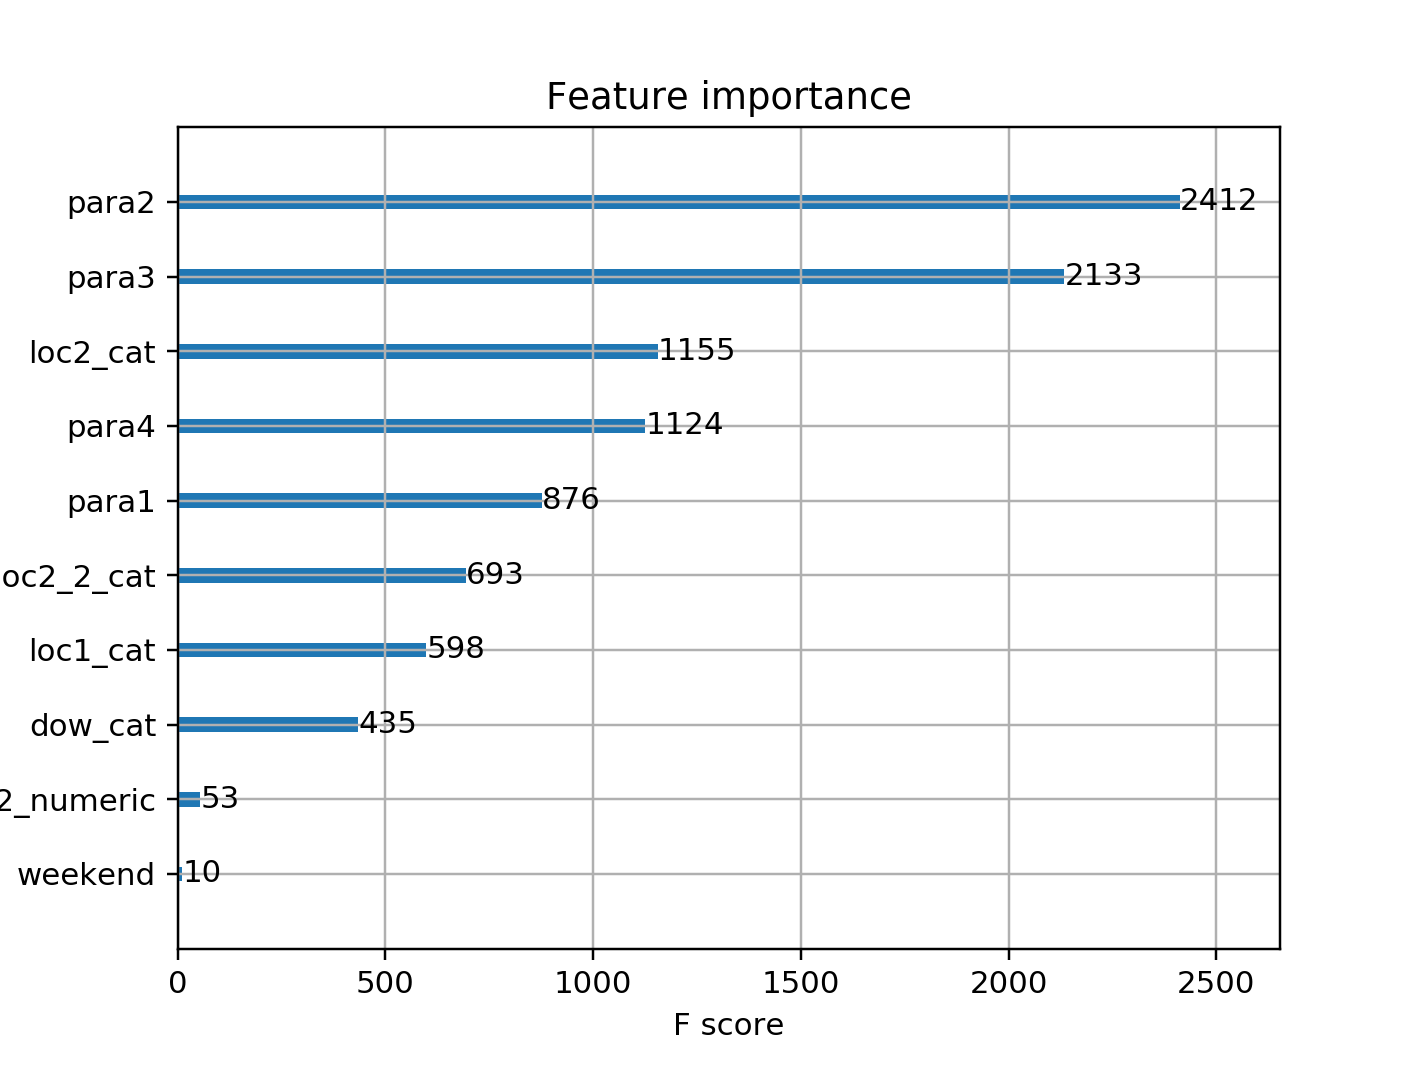

Root mean square error on validation fold=  140.372248983

Fold:  1


<IPython.core.display.Javascript object>


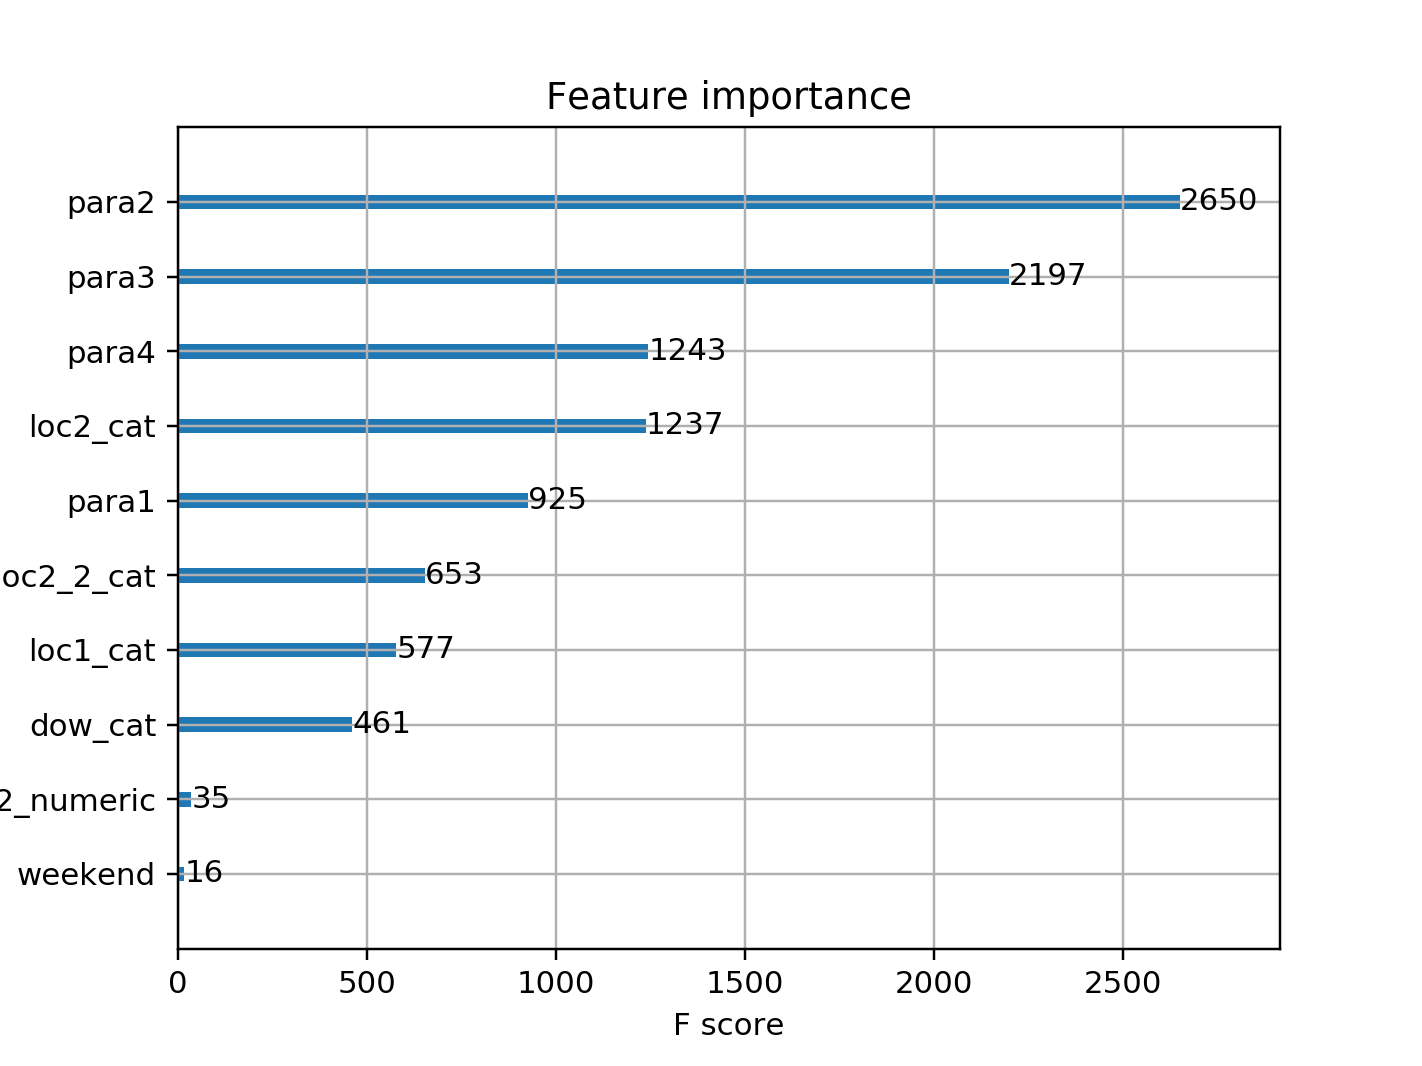

Root mean square error on validation fold=  163.472459966

Fold:  2


<IPython.core.display.Javascript object>


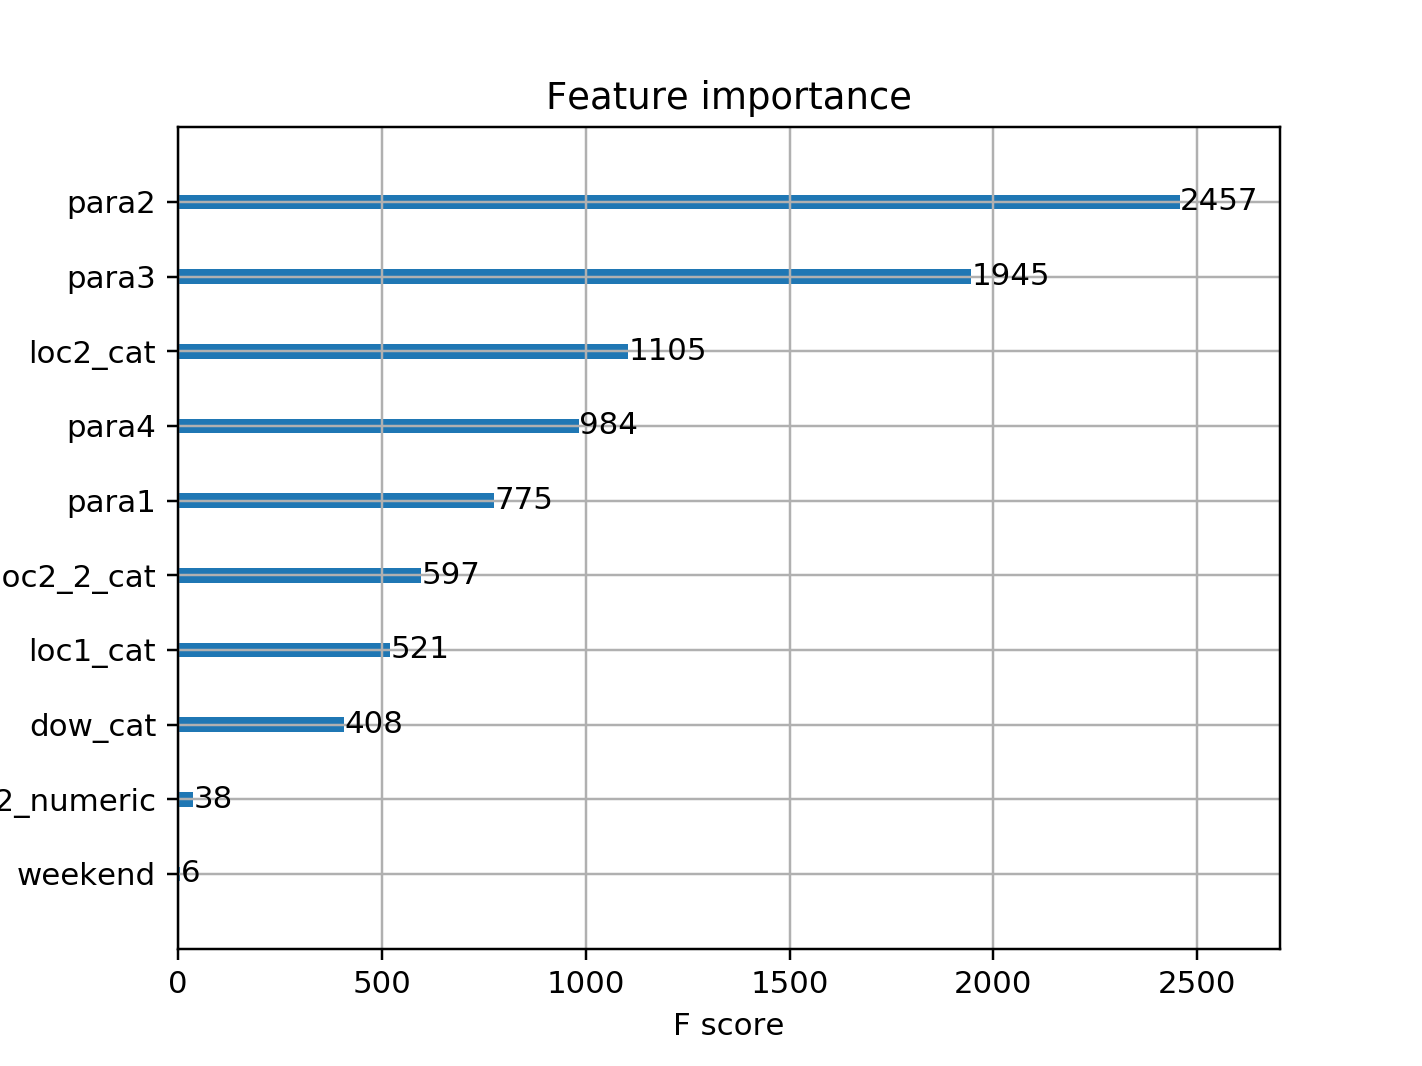

Root mean square error on validation fold=  158.140626026

Fold:  3


<IPython.core.display.Javascript object>


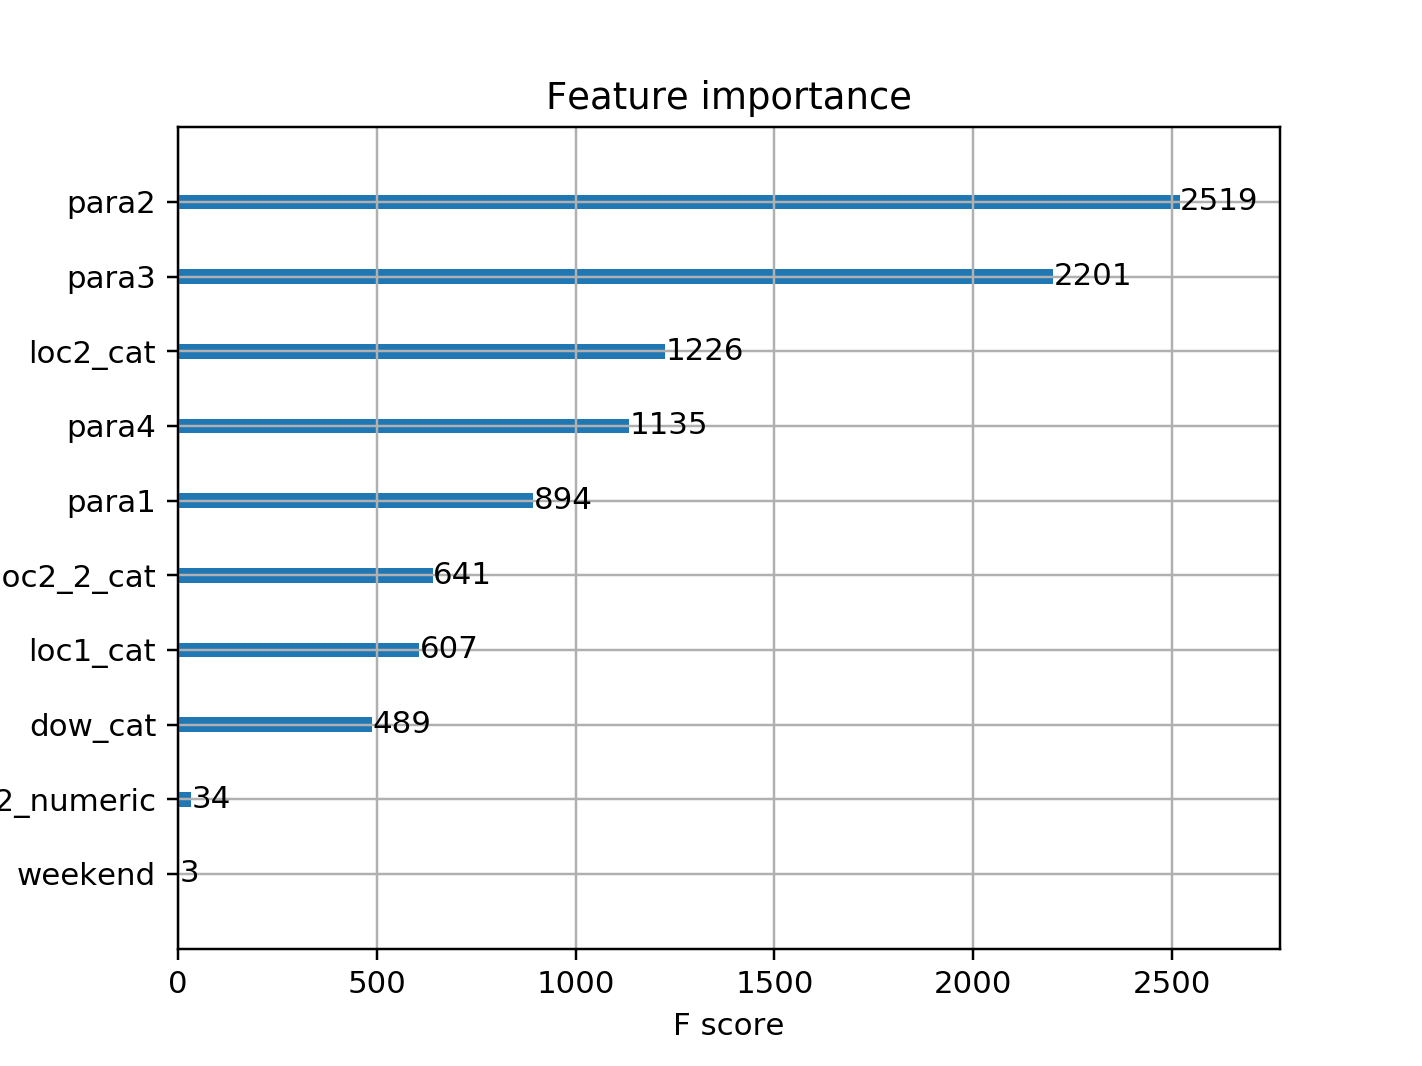

Root mean square error on validation fold=  154.436630133

Fold:  4


<IPython.core.display.Javascript object>


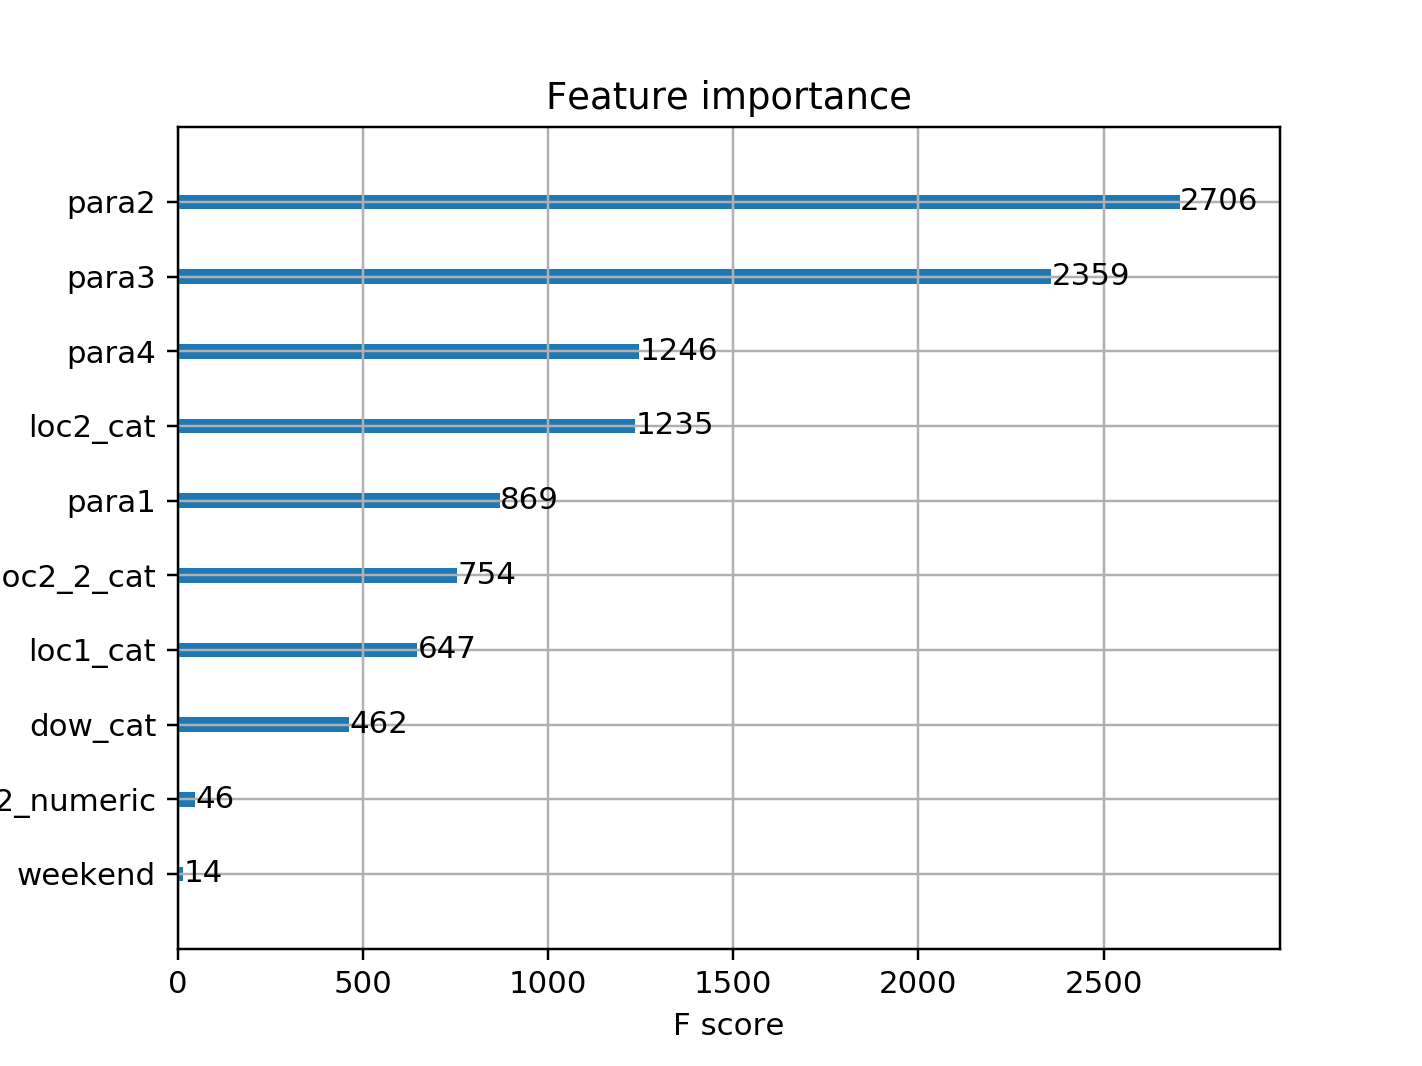

Root mean square error on validation fold=  151.649131059
Averaged RMSE with standard deviation on hold out data: 153.6142 +- 7.7144


In [36]:
# k-fold cross validation
errors = []
for i, (train_index, test_index) in enumerate(kf.split(X_train)):  
    # Select data for this fold
    y_train_cv, y_valid_cv = y_train.iloc[train_index].copy(), y_train.iloc[test_index]
    X_train_cv, X_valid_cv = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
    print( "\nFold: ", i)
    model.fit(X_train_cv, y_train_cv)
    # plot features ordered by importance
    plot_importance(model)    
    # Generate predictions on the validation fold
    pred = model.predict(X_valid_cv)
    errors.append(rmse(y_valid_cv, pred))
    print( "Root mean square error on validation fold= ", rmse(y_valid_cv, pred) )    
    del X_train_cv, X_valid_cv, y_train_cv
    
print('Averaged RMSE with standard deviation on hold out data: {:02.4f} +- {:02.4f}'.format(np.mean(errors), np.std(errors)))
  

Removing the features with low importance in all folds, 'loc2_numeric' and 'weekend':

In [37]:
X_train.drop(['weekend', 'loc2_numeric'], axis=1, inplace=True )
X_test.drop(['weekend', 'loc2_numeric'], axis=1, inplace=True )

/System/Library/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/System/Library/anaconda/envs/python35/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [38]:
pred_test = np.zeros_like(y_test)
errors = []
for i, (train_index, test_index) in enumerate(kf.split(X_train)):  
    # Select data for this fold
    y_train_cv, y_valid_cv = y_train.iloc[train_index].copy(), y_train.iloc[test_index].copy()
    X_train_cv, X_valid_cv = X_train.iloc[train_index].copy(), X_train.iloc[test_index].copy()
    print( "\nFold: ", i)
    model.fit(X_train_cv, y_train_cv)
    # Generate predictions on the validation fold
    pred = model.predict(X_valid_cv)
    pred_test += model.predict(X_test)
    errors.append(rmse(y_valid_cv, pred))
    print( "Root mean square error on validation fold= ", rmse(y_valid_cv, pred) )    
    del X_train_cv, X_valid_cv, y_train_cv
    

print('\nAveraged RMSE with standard deviation on hold out data: {:02.4f} +- {:02.4f}'.format(np.mean(errors), np.std(errors)))
pred_test = pred_test/K
print('RMSE on hold out test data: {}'.format(rmse(y_test, pred_test)))


Fold:  0
Root mean square error on validation fold=  140.101681671

Fold:  1
Root mean square error on validation fold=  166.474198728

Fold:  2
Root mean square error on validation fold=  160.403345267

Fold:  3
Root mean square error on validation fold=  153.837522812

Fold:  4
Root mean square error on validation fold=  150.56782587

Averaged RMSE with standard deviation on hold out data: 154.2769 +- 8.9576
RMSE on hold out test data: 155.90649749808995


Removing `weekend` and  `loc2_numeric` hasn't improved the averaged RMSE. So they could be kept as part of the data. It can be seen that 
results on the unseen test data are close to the results on the validation data. This indicates that our model is able to generalize and to predict reliably unseen data.

To improve the results further we could try to use several models as part of an Ensemble. Predict the prices on the test set with different models and use linear regression to combine the predictions in a final prediction. Furthermore, we could dive deeper into the dependencies between the variables and try to define additonal features.